In [1]:
import pandas as pd

url = "https://data.montgomerycountymd.gov/api/views/v76h-r7br/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)

In [2]:
print(df.shape)
df.head()


(307645, 9)


,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0


In [3]:
df.columns
df.isna().sum().sort_values(ascending=False).head(15)
df.describe(include="all").T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
YEAR,307645.0,NaN,NaN,NaN,2018.438525,1.083061,2017.0,2017.0,2019.0,2019.0,2020.0
MONTH,307645.0,NaN,NaN,NaN,6.423862,3.461812,1.0,3.0,7.0,9.0,12.0
SUPPLIER,307478,396,REPUBLIC NATIONAL DISTRIBUTING CO,20995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM CODE,307645,34056,102032,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM DESCRIPTION,307645,34822,BURGANS ALBARINO - 750ML,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM TYPE,307644,8,WINE,187640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RETAIL SALES,307642.0,NaN,NaN,NaN,7.024071,30.986238,-6.49,0.0,0.32,3.2675,2739.0
RETAIL TRANSFERS,307645.0,NaN,NaN,NaN,6.936465,30.237195,-38.49,0.0,0.0,3.0,1990.83
WAREHOUSE SALES,307645.0,NaN,NaN,NaN,25.294597,249.916798,-7800.0,0.0,1.0,5.0,18317.0


In [4]:
df["WAREHOUSE SALES"] = df["WAREHOUSE SALES"].clip(lower=0)
df["RETAIL SALES"] = df["RETAIL SALES"].clip(lower=0)
df["RETAIL TRANSFERS"] = df["RETAIL TRANSFERS"].clip(lower=0)


In [5]:
data = df[[
    "YEAR",
    "MONTH",
    "ITEM TYPE",
    "RETAIL SALES",
    "RETAIL TRANSFERS",
    "WAREHOUSE SALES"
]].copy()


In [6]:
data = pd.get_dummies(data, columns=["ITEM TYPE"], drop_first=True)
data.head()


,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,ITEM TYPE_DUNNAGE,ITEM TYPE_KEGS,ITEM TYPE_LIQUOR,ITEM TYPE_NON-ALCOHOL,ITEM TYPE_REF,ITEM TYPE_STR_SUPPLIES,ITEM TYPE_WINE
0,2020,1,0.00,0.0,2.0,False,False,False,False,False,False,True
1,2020,1,0.00,1.0,4.0,False,False,False,False,False,False,True
2,2020,1,0.00,0.0,1.0,False,False,False,False,False,False,False
3,2020,1,0.00,0.0,1.0,False,False,False,False,False,False,True
4,2020,1,0.82,0.0,0.0,False,False,False,False,False,False,True


In [7]:
from sklearn.model_selection import train_test_split

X = data.drop("WAREHOUSE SALES", axis=1)
y = data["WAREHOUSE SALES"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


(246116, 11) (61529, 11)


In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 26.961968549002126
RMSE: 193.53912230836687


In [10]:
import pandas as pd

importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.head(10)


,0
RETAIL SALES,0.366042
RETAIL TRANSFERS,0.353631
ITEM TYPE_LIQUOR,0.127763
MONTH,0.067025
YEAR,0.040903
ITEM TYPE_WINE,0.036864
ITEM TYPE_NON-ALCOHOL,0.005163
ITEM TYPE_KEGS,0.001257
ITEM TYPE_STR_SUPPLIES,0.000703
ITEM TYPE_REF,0.000626


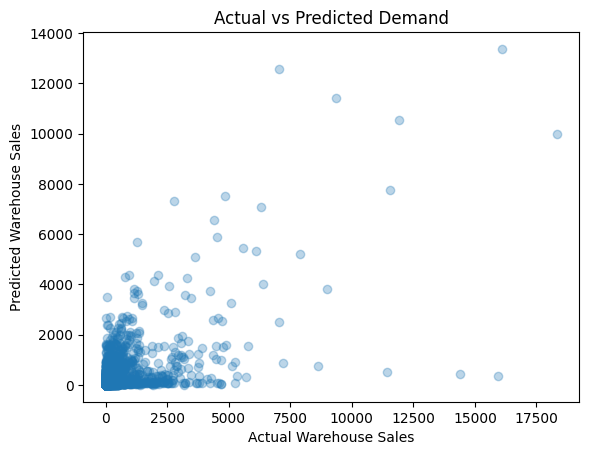

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel("Actual Warehouse Sales")
plt.ylabel("Predicted Warehouse Sales")
plt.title("Actual vs Predicted Demand")
plt.show()


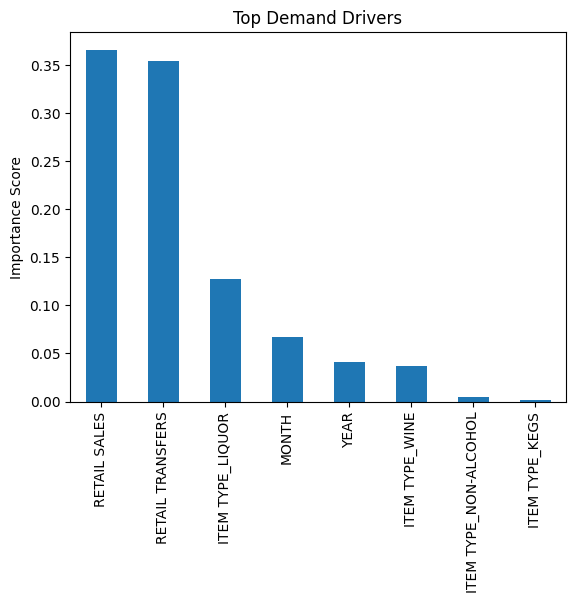

In [12]:
importance.head(8).plot(kind="bar")
plt.title("Top Demand Drivers")
plt.ylabel("Importance Score")
plt.show()
